# **Ensemble learning and XAI**
**Ensemble Learning** is a machine learning approach that combines predictions from multiple models to improve accuracy and reliability, using methods like Bagging (reducing variance), Boosting (reducing bias), and Stacking(combining diverse models). It enhances performance by leveraging the strengths of individual models. Explainable AI (XAI), on the other hand, aims to make AI systems transparent and understandable by providing insights into how models make decisions. Using techniques like SHAP, LIME, and feature importance analysis, XAI helps build trust, enables debugging, and ensures AI solutions align with ethical standards and user expectations.

# Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Loading the Dataset

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/CSE475/Ensemble learning and XAI/cw_22_23_24.csv')
df2.head()

adm_type shift_from ssc  yr_nae  m_no       mrn          pt_name sex  \
0  Shift From         ER  No       1     1  21845698        Hara Bibi   F   
1  Shift From         ER  No       2     2  22000071       Taj Rehman   M   
2  Shift From         ER  No       3     3  21838760   Bakhtawar Shah   M   
3  Shift From         ER  No       4     4  22000251  Arasal Jan Bibi   F   
4  Shift From        Neu  No       5     5  21825110       Khad Mewa    F   

  disease     D.O.A      D.O.D     status    consultant  L.O.S  
0   STEMI  1-Jan-22   1-Jan-22  Discharge    Imran Khan      0  
1    ADHF  1-Jan-22   5-Jan-22  Discharge  Malik Faisal      4  
2     ihd  1-Jan-22  10-Jan-22  Discharge    Asif Iqbal      9  
3     NaN  1-Jan-22   7-Jan-22  Discharge  Sher Bahadar      6  
4     NaN  1-Jan-22   2-Jan-22  Discharge   Tariq Nawaz      1

In [ ]:

df_half = df2.sample(frac=0.5, random_state=42)  # Keeps 50% randomly
df1 = df2.drop(df_half.index)           # Drops the selected half

print("Sampled Half Dataset:")
print(df_half)

print("\nRemaining Dataset:")
print(df1)


Sampled Half Dataset:
        adm_type shift_from  ssc  yr_nae  m_no       mrn         pt_name sex  \
6296  Shift From         ER   No    2622    28   5801495      Gul Zubana   F   
1496  Shift From         ER   No    1497   257  22376672  Khadim Hussain   M   
5040  Shift From         ER  yes    1366   120   5286931    Jameela Bibi   F   
8486  Shift From         ER  yes     887   250   6593800      Mir Bahala   F   
8959  Shift From         ER  yes    1360    45   6777953     Ikram Ullah   M   
...          ...        ...  ...     ...   ...       ...             ...  ..   
6756  Shift From         ER  yes    3082   159   6013049       Wazir Gul   F   
4446  Shift From         ER  yes     772   152   5072308    Wilayat Shah   M   
4460         OPD        OPD  yes     786   166   5024260     Zar Khubani   F   
6181  Shift From         ER  yes    2507   297   5771035         M.qasim   M   
2505         OPD        OPD   No    2506    56   4658282      Riaz Uddin   M   

         disease 

In [ ]:
unique_values = df2['yr_nae'].unique()
print(unique_values)

[   1    2    3 ... 3923 3924 3925]


In [ ]:
df = df1.drop(columns=['pt_name', 'mrn', 'D.O.A', 'm_no', 'yr_nae','consultant'])
df.head()

adm_type shift_from ssc sex disease      D.O.D     status  L.O.S
1  Shift From         ER  No   M    ADHF   5-Jan-22  Discharge      4
2  Shift From         ER  No   M     ihd  10-Jan-22  Discharge      9
4  Shift From        Neu  No   F     NaN   2-Jan-22  Discharge      1
5  Shift From         ER  No   M     NaN   3-Jan-22  Discharge      2
6  Shift From         ER  No   M     NaN   5-Jan-22  Discharge      4

# Data Preprocessing
Handle missing values, if any.Encode categorical variables.Feature scaling (if necessary)

In [ ]:
X = df.drop(['status'], axis=1)
print(X)
#This operation reduces each class label by 1, assuming
#class labels originally start from 1. If classes were
#initially numbered as 1, 2, 3, etc., they’ll now be 0, 1, 2, etc.



#Many machine learning algorithms in Python
#(especially in libraries like scikit-learn)
#expect class labels to start from 0. This
#adjustment simplifies compatibility with
#these algorithms and avoids indexing issues.
# y = df['loan_status']-1
y = df['status']

#Identifying Feature Types:

# Split the features into categorical and numerical

#Selects the columns containing categorical data
categorical_features = X.select_dtypes(include=['object']).columns

#Selects columns containing numerical data
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


#Data Preprocessing:

# Standard scaling for numerical features only

#will adjust the data so that each feature has
#a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

#first learns the mean and standard deviation for
#each numerical feature in X.
#This helps ensure that all numerical features are on a similar scale.

#this process centers the data around zero and adjusts the scale,
#which often improves the performance of machine learning models
#by preventing any one feature from dominating due to its larger scale.
scaled_numerical_data = scaler.fit_transform(X[numerical_features])

# One-hot encoding for categorical features only

#The OneHotEncoder converts categorical variables
#into binary (one-hot) encoded variables.
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(X[categorical_features])

# Concatenate the scaled numerical and encoded categorical data

#Concatenates the scaled numerical and encoded categorical arrays horizontally,
#combining them into a single dataset.
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Convert to DataFrame with appropriate column names
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
final_df = pd.DataFrame(processed_data, columns=final_columns)

#Stores the preprocessed features in data_X for modeling
data_X = final_df.copy()

        adm_type shift_from  ssc sex disease      D.O.D  L.O.S
1     Shift From         ER   No   M    ADHF   5-Jan-22      4
2     Shift From         ER   No   M     ihd  10-Jan-22      9
4     Shift From        Neu   No   F     NaN   2-Jan-22      1
5     Shift From         ER   No   M     NaN   3-Jan-22      2
6     Shift From         ER   No   M     NaN   5-Jan-22      4
...          ...        ...  ...  ..     ...        ...    ...
9564  Shift From         ER  yes   M     IHD   5-Jul-24      5
9565  Shift From         ER  yes   M  NSTEMI   6-Jul-24      6
9567  Shift From         ER  yes   F    AWMI   2-Jul-24      2
9570  Shift From         ER  yes   M      MI   4-Jul-24      4
9572  Shift From  Post Cath  yes   F    AWMI   1-Jul-24      1

[4787 rows x 7 columns]


In [ ]:
'''ya = df['status']
print(ya)'''

"ya = df['status']\nprint(ya)"

In [ ]:
data_X.head()

L.O.S  adm_type_IBP  adm_type_OPD  adm_type_Shift From  adm_type_opd  \
0  0.104213           0.0           0.0                  1.0           0.0   
1  1.408095           0.0           0.0                  1.0           0.0   
2 -0.678117           0.0           0.0                  1.0           0.0   
3 -0.417340           0.0           0.0                  1.0           0.0   
4  0.104213           0.0           0.0                  1.0           0.0   

   shift_from_AMU-F  shift_from_AMU-M  shift_from_ANGIO  shift_from_AmU  \
0               0.0               0.0               0.0             0.0   
1               0.0               0.0               0.0             0.0   
2               0.0               0.0               0.0             0.0   
3               0.0               0.0               0.0             0.0   
4               0.0               0.0               0.0             0.0   

   shift_from_AnGIO DC  ...  D.O.D_9-Mar-24  D.O.D_9-May-22  D.O.D_9-May-23  \
0                  0.0  ...             0.0             0.0             0.0   
1                  0.0  ...             0.0             0.0             0.0   
2                  0.0  ...             0.0             0.0             0.0   
3                  0.0  ...             0.0             0.0             0.0   
4                  0.0  ...             0.0             0.0             0.0   

   D.O.D_9-May-24  D.O.D_9-Nov-22  D.O.D_9-Nov-23  D.O.D_9-Oct-22  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   D.O.D_9-Oct-23  D.O.D_9-Sep-22  D.O.D_9-Sep-23  
0             0.0             0.0             0.0  
1             0.0             0.0             0.0  
2             0.0             0.0             0.0  
3             0.0             0.0             0.0  
4             0.0             0.0             0.0  

[5 rows x 1502 columns]

The code splits the dataset `X` and labels `y` into training and testing sets, allocating 20% for testing, using a fixed random seed (42) for reproducibility.

In [ ]:
X = data_X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Approach: Random Forest

In [ ]:
#Random Forest Classifier Initialization
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#Training the Model
rf_model.fit(X_train, y_train)
#Making Predictions
rf_pred = rf_model.predict(X_test)
#Evaluating the Model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.8820459290187892


# Boosting Approach: Gradient Boosting
This code trains a Gradient Boosting Classifier with 100 estimators, fits it on the training data (X_train, y_train), makes predictions on the test data (X_test), and prints the accuracy of the predictions compared to the true labels (y_test).

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))

Gradient Boosting Accuracy: 0.8810020876826722


# Stacking Approach
Use a meta-classifier (e.g., Logistic Regression) on top of base learners

In [ ]:
!pip install scikit-learn==1.3.0

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Base learners
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))  # No wrapper needed
]

# Meta-learner
meta_learner = LogisticRegression()

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Fit the model
stacking_model.fit(X_train, y_train)

# Predict and evaluate
stacking_pred = stacking_model.predict(X_test)
print("Stacking Model Accuracy:", accuracy_score(y_test, stacking_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Model Accuracy: 0.8997912317327766


# Combine multiple classifiers by voting.
This code creates a soft voting ensemble classifier using three models (Random Forest, Gradient Boosting, and SVC), trains it on the training data (X_train, y_train), makes predictions on the test data (X_test), and prints the accuracy of the predictions against the true labels (y_test).

In [ ]:
#This ensemble model combines several base models—Random Forest,
#Gradient Boosting, and Support Vector Classifier (SVC)—to
#make predictions. The voting='soft' parameter indicates that
#the classifier will use the probabilities predicted by each model
#and then average them to make final predictions.
#This "soft voting" often yields better results when
#the models provide probability estimates.


vote_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)
vote_model.fit(X_train, y_train)
vote_pred = vote_model.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, vote_pred))


Voting Classifier Accuracy: 0.8987473903966597


# Evaluation
Compare the performance of all models.

In [ ]:
print("Random Forest:", accuracy_score(y_test, rf_pred))
print("Gradient Boosting:", accuracy_score(y_test, gb_pred))
print("Stacking Model:", accuracy_score(y_test, stacking_pred))
print("Voting Classifier:", accuracy_score(y_test, vote_pred))


Random Forest: 0.8820459290187892
Gradient Boosting: 0.8810020876826722
Stacking Model: 0.8997912317327766
Voting Classifier: 0.8987473903966597


# Cross-Validation Performance Comparison
Use cross_val_score from sklearn.model_selection to perform cross-validation and evaluate each ensemble model's accuracy across folds.Set cv=5 for 5-fold cross-validation (can be adjusted based on preference or dataset size).

In [ ]:
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        final_estimator=LogisticRegression()
    ),
    "Voting": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        voting='soft'
    )
}

# Perform cross-validation and store results

#scores.mean() gives the average accuracy across all folds.
#scores.std() provides the variability in accuracy between the folds.
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, data_X, y, cv=2, scoring='accuracy')
    results[model_name] = scores
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest Cross-Validation Accuracy: 0.8937 ± 0.0023
Gradient Boosting Cross-Validation Accuracy: 0.8878 ± 0.0032
Stacking Cross-Validation Accuracy: 0.8974 ± 0.0002
Voting Cross-Validation Accuracy: 0.8966 ± 0.0002


# Visualizing Cross-Validation Results
This code creates a DataFrame results_df to hold cross-validation accuracy scores of different ensemble models, then uses a box plot to visually compare the models' performance by plotting the distribution of accuracy scores for each model, with proper labels and formatting for clarity.

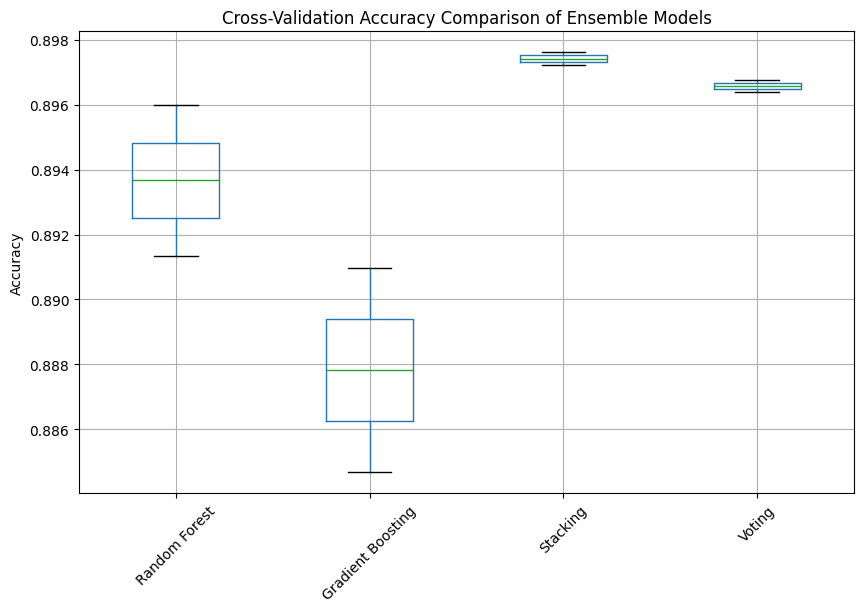

In [ ]:
import matplotlib.pyplot as plt

# Prepare results for visualization
import pandas as pd

#converted into a pandas DataFrame (results_df).
#This allows for easier manipulation and visualization.
results_df = pd.DataFrame(results)

# Plot box plot for model comparison
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title("Cross-Validation Accuracy Comparison of Ensemble Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


# Confusion Matrix for Each Model

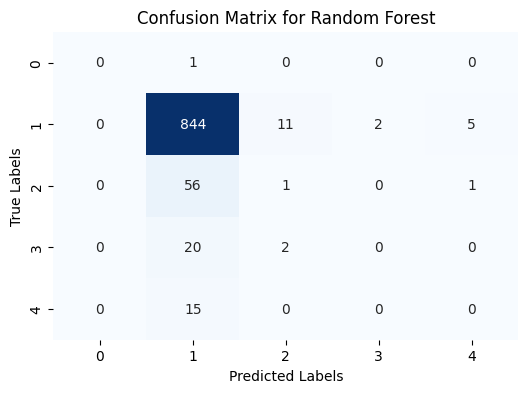

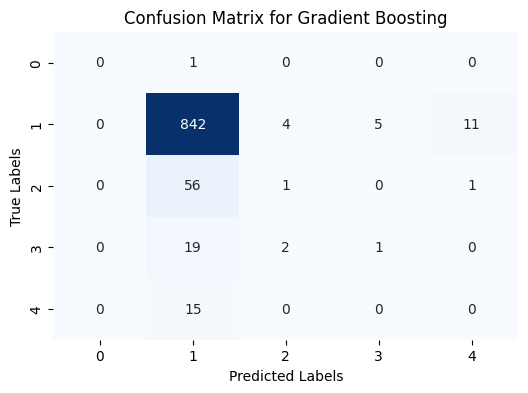

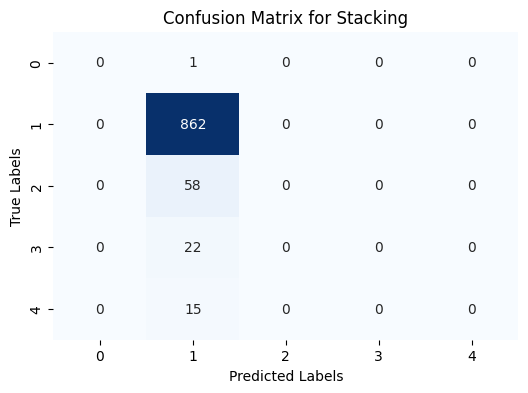

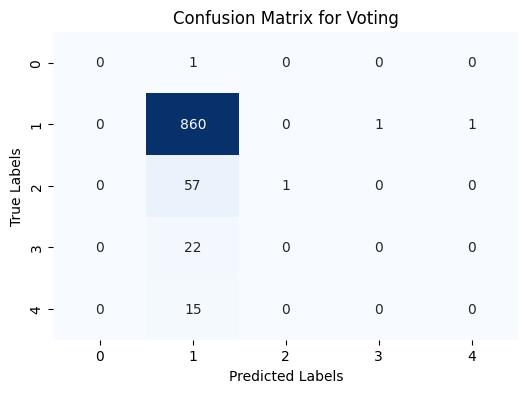

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fit each model on the training data and plot the confusion matrix for each
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


# Precision and Recall for Each Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fit each model on the training data and calculate precision, recall, and F1-score
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"{model_name} Performance Metrics:")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1 Score: {f1:.4f}\n")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Performance Metrics:
 - Precision: 0.8157
 - Recall: 0.8820
 - F1 Score: 0.8464



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gradient Boosting Performance Metrics:
 - Precision: 0.8245
 - Recall: 0.8810
 - F1 Score: 0.8477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Stacking Performance Metrics:
 - Precision: 0.8096
 - Recall: 0.8998
 - F1 Score: 0.8523

Voting Performance Metrics:
 - Precision: 0.8708
 - Recall: 0.8987
 - F1 Score: 0.8538



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Summary of Metrics

In [ ]:
# Collect all metrics in a DataFrame for summary
metrics_summary = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert to DataFrame
import pandas as pd
metrics_df = pd.DataFrame(metrics_summary)

# Display the summary
print("Model Performance Summary:")
metrics_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Performance Summary:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model  Accuracy  Precision    Recall  F1 Score
0      Random Forest  0.882046   0.815675  0.882046  0.846425
1  Gradient Boosting  0.881002   0.824507  0.881002  0.847653
2           Stacking  0.899791   0.809624  0.899791  0.852330
3             Voting  0.898747   0.870826  0.898747  0.853808

# Explainable AI (XAI)

## Explaining Model Predictions Using SHAP
SHAP provides detailed insights into feature contributions for individual predictions and the overall model. We'll compute SHAP values for the Random Forest model as an example, but this approach can be extended to other models as well.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
!pip install --upgrade shap

In [ ]:
X_sample = X_test.sample(50, random_state=42)

In [ ]:
X_sample

L.O.S  adm_type_IBP  adm_type_OPD  adm_type_Shift From  adm_type_opd  \
2776 -0.417340           0.0           0.0                  1.0           0.0   
3895  4.276637           0.0           0.0                  1.0           0.0   
4765  0.104213           0.0           0.0                  1.0           0.0   
2988 -0.678117           0.0           0.0                  1.0           0.0   
410  -0.417340           0.0           0.0                  1.0           0.0   
2692  3.494307           0.0           0.0                  1.0           0.0   
4074 -0.678117           0.0           0.0                  1.0           0.0   
478   1.147319           0.0           0.0                  1.0           0.0   
4372 -0.156564           0.0           0.0                  1.0           0.0   
84    1.929648           0.0           0.0                  1.0           0.0   
828  -0.417340           0.0           0.0                  1.0           0.0   
3392  0.104213           0.0           0.0                  1.0           0.0   
2592 -0.417340           0.0           0.0                  1.0           0.0   
1767 -0.156564           0.0           0.0                  1.0           0.0   
2127  0.364989           0.0           0.0                  1.0           0.0   
122  -0.678117           0.0           0.0                  1.0           0.0   
79    5.580519           0.0           0.0                  1.0           0.0   
1129 -0.417340           0.0           0.0                  1.0           0.0   
3231 -0.156564           0.0           0.0                  1.0           0.0   
535   0.364989           0.0           0.0                  1.0           0.0   
279  -0.678117           0.0           0.0                  1.0           0.0   
4256 -0.678117           0.0           0.0                  1.0           0.0   
4344 -0.156564           0.0           0.0                  1.0           0.0   
1360 -0.156564           0.0           1.0                  0.0           0.0   
4060 -0.678117           0.0           0.0                  1.0           0.0   
2809 -0.678117           0.0           0.0                  1.0           0.0   
3411 -0.678117           0.0           0.0                  1.0           0.0   
567   0.104213           0.0           0.0                  1.0           0.0   
1729  2.711978           0.0           0.0                  1.0           0.0   
1522  0.886542           0.0           0.0                  1.0           0.0   
45    0.364989           0.0           0.0                  1.0           0.0   
1438  3.233531           0.0           0.0                  1.0           0.0   
1612  0.625766           0.0           0.0                  1.0           0.0   
3435 -0.417340           0.0           0.0                  1.0           0.0   
3425  0.104213           0.0           0.0                  1.0           0.0   
3360 -0.678117           0.0           0.0                  1.0           0.0   
751  -0.417340           0.0           0.0                  1.0           0.0   
4151  0.104213           0.0           0.0                  1.0           0.0   
248  -0.678117           0.0           0.0                  1.0           0.0   
896  -0.678117           0.0           0.0                  1.0           0.0   
3387  0.886542           0.0           0.0                  1.0           0.0   
1421 -0.156564           0.0           0.0                  1.0           0.0   
3182 -0.156564           0.0           0.0                  1.0           0.0   
3984  3.755084           0.0           0.0                  1.0           0.0   
3955 -0.678117           0.0           0.0                  1.0           0.0   
2409 -0.417340           0.0           0.0                  1.0           0.0   
43    1.408095           0.0           0.0                  1.0           0.0   
1532 -0.678117           0.0           0.0                  1.0           0.0   
239  -0.156564           0.0           0

In [ ]:
X_train

L.O.S  adm_type_IBP  adm_type_OPD  adm_type_Shift From  adm_type_opd  \
708  -0.156564           0.0           0.0                  1.0           0.0   
2649 -0.156564           0.0           0.0                  1.0           0.0   
1451  0.625766           0.0           0.0                  1.0           0.0   
4510 -0.678117           0.0           0.0                  1.0           0.0   
1691 -0.156564           0.0           0.0                  1.0           0.0   
...        ...           ...           ...                  ...           ...   
4426 -0.678117           0.0           0.0                  1.0           0.0   
466  -0.156564           0.0           0.0                  1.0           0.0   
3092  0.364989           1.0           0.0                  0.0           0.0   
3772 -0.678117           0.0           0.0                  1.0           0.0   
860   0.104213           0.0           0.0                  1.0           0.0   

      shift_from_AMU-F  shift_from_AMU-M  shift_from_ANGIO  shift_from_AmU  \
708                0.0               0.0               0.0             0.0   
2649               0.0               0.0               0.0             0.0   
1451               0.0               0.0               0.0             0.0   
4510               0.0               0.0               0.0             0.0   
1691               0.0               0.0               0.0             0.0   
...                ...               ...               ...             ...   
4426               0.0               0.0               0.0             0.0   
466                0.0               0.0               0.0             0.0   
3092               0.0               0.0               0.0             0.0   
3772               0.0               0.0               0.0             0.0   
860                0.0               0.0               0.0             0.0   

      shift_from_AnGIO DC  ...  D.O.D_9-Mar-24  D.O.D_9-May-22  \
708                   0.0  ...             0.0             0.0   
2649                  0.0  ...             0.0             0.0   
1451                  0.0  ...             0.0             0.0   
4510                  0.0  ...             0.0             0.0   
1691                  0.0  ...             0.0             0.0   
...                   ...  ...             ...             ...   
4426                  0.0  ...             0.0             0.0   
466                   0.0  ...             0.0             0.0   
3092                  0.0  ...             0.0             0.0   
3772                  0.0  ...             0.0             0.0   
860                   0.0  ...             0.0             0.0   

      D.O.D_9-May-23  D.O.D_9-May-24  D.O.D_9-Nov-22  D.O.D_9-Nov-23  \
708              0.0             0.0             0.0             0.0   
2649             0.0             0.0             0.0             0.0   
1451             0.0             0.0             0.0             0.0   
4510             0.0             0.0             0.0             0.0   
1691             0.0             0.0             0.0             0.0   
...              ...             ...             ...             ...   
4426             0.0             0.0             0.0             0.0   
466              0.0             0.0             0.0             0.0   
3092             0.0             0.0             0.0             0.0   
3772             0.0             0.0             0.0             0.0   
860              0.0             0.0             0.0             0.0   

      D.O.D_9-Oct-22  D.O.D_9-Oct-23  D.O.D_9-Sep-22  D.O.D_9-Sep-23  
708              0.0             0.0             0.0             0.0  
2649             0.0             0.0             0.0             0.0  
1451             0.0             0.0             0.0             0.0  
4510             0.0             0.0             0.0             0.0  
1691             0.0             0.0             0.0             0.0  
...            

In [ ]:
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming these are categorical and numerical features:
categorical_features = X_sample.select_dtypes(include=['object']).columns
numerical_features = X_sample.select_dtypes(include=['int64', 'float64']).columns

# Define the preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # sparse=False for SHAP
])

# Create the ColumnTransformer to apply transformations to specific columns
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessing pipeline on your training data (important!)
preprocessing_pipeline.fit(X_train)  # Use your training data here (X_train)

# Apply preprocessing pipeline
X_sample_preprocessed = preprocessing_pipeline.transform(X_sample[:10])

# Initialize the SHAP explainer with the trained model
explainer = shap.TreeExplainer(models["Random Forest"])

# Calculate SHAP values using the preprocessed sample data
shap_values = explainer.shap_values(X_sample_preprocessed, check_additivity=False)
print(shap_values)

[[[ 8.32895209e+61 -7.53844778e+61 -6.98226115e+56 -1.24705278e+47
   -6.83827519e+45]
  [-1.04372557e+40 -8.82043019e+60  4.47650730e+58  5.91891297e+49
   -7.59255022e+43]
  [-2.46922331e+63  9.49335200e+62  3.11026369e+58  1.04512882e+50
    3.36152996e+44]
  ...
  [ 6.78567091e+36  1.76401273e+68  7.08983642e+65 -6.51006079e+28
   -4.19222656e+41]
  [-1.62038144e+43  1.23615992e+68  1.92372667e+67  2.50975198e+51
    2.91209015e+48]
  [-3.03425582e+48 -1.84277192e+61  1.13046867e+61  4.71703986e+50
    4.92683974e+44]]

 [[-8.61531153e+42  3.87167845e+53 -3.10880268e+53  7.18991397e+44
    2.16560105e+46]
  [-1.18919326e+39  6.43420554e+59 -8.43158699e+56  3.62264993e+50
    4.66127542e+43]
  [-8.14997904e+62 -1.16159424e+63 -3.08583097e+56  5.92936351e+50
    9.28943421e+43]
  ...
  [-1.36958865e+37  8.29117750e+65 -7.98823098e+66 -2.36025437e+28
   -1.45530506e+38]
  [-1.08941907e+43  5.37879054e+65 -4.05870280e+66  1.12916086e+50
    6.15435746e+46]
  [ 5.93769019e+47  1.0233505

## illustrates the feature importance in terms of the average impact each feature has on the model's predictions

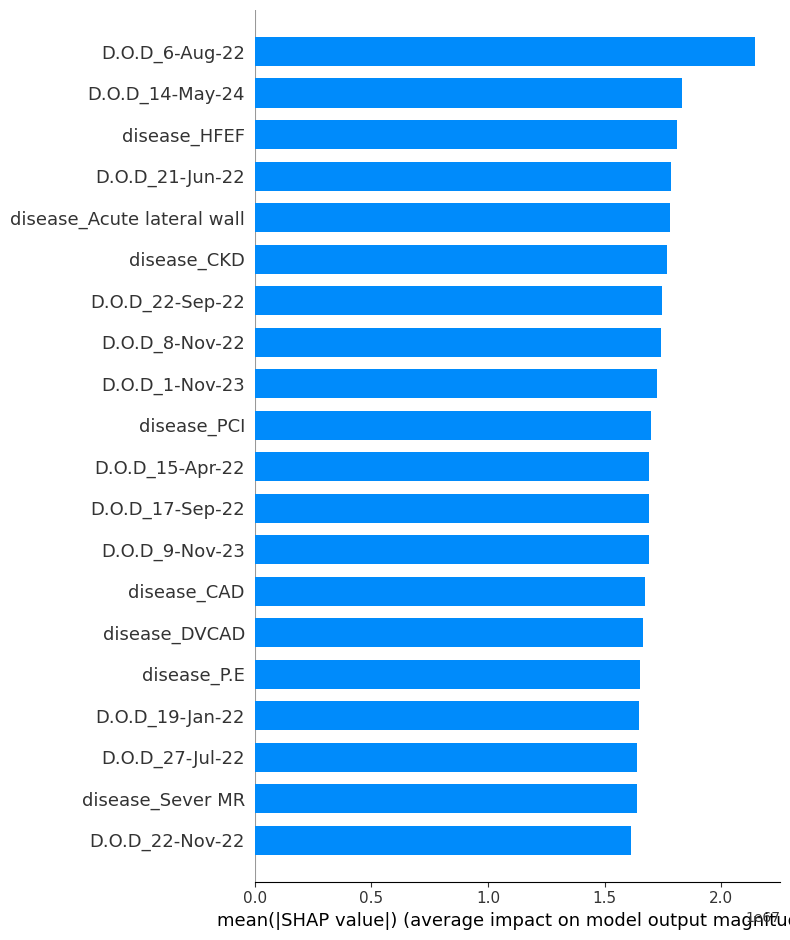

In [ ]:
import numpy as np

# Calculate mean absolute SHAP values across all classes for each feature

#This step calculates the mean absolute SHAP value for each feature.

#The shap_values array contains the SHAP values for all instances in X_sample,
#and by taking the absolute value and averaging across all instances, we get
#an overall measure of each feature's contribution to the model's predictions.

mean_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # Resulting shape should be (100, 12) to match X_sample

# If mean_shap_values is (12, 5), take the mean across classes, resulting in a vector (12, )

#If there are multiple classes (for multi-class classification), this line computes the mean
#SHAP value across all classes, collapsing the results to a single value for each feature.

mean_shap_values = np.mean(mean_shap_values, axis=1)



# Repeat this vector to create a matrix that matches X_sample's shape

#This step repeats the mean_shap_values for each row in the sample data.
#This is necessary to create a shape that matches the original X_sample for visualization.
mean_shap_values_repeated = np.tile(mean_shap_values, (X_sample.shape[0], 1))


# Plot the summary plot with the repeated matrix
shap.summary_plot(mean_shap_values_repeated, X_sample, plot_type="bar", feature_names=X_sample.columns)


# Explaining Model Predictions Using LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7154459aa9af950f8448555b1dce59aa9af005fcaa0d76a0d0bfca9b51f06d1e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# LIME's LimeTabularExplainer provides a simple way to explain individual predictions of a model by approximating it locally with an interpretable model, highlighting the most influential features for that prediction.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=data_X.columns, class_names=y.values, mode='classification')

# Choose a sample from the test set to explain
sample_index = 0 # Adjust to analyze a different sample

#Generate the Explanation
#This generates a local explanation for the chosen test instance using the Random Forest model’s predicted probabilities

exp = lime_explainer.explain_instance(X_test.values[sample_index], models["Random Forest"].predict_proba, num_features=10)
print(X_test.values[sample_index])
# Display the explanation
exp.show_in_notebook()
exp.show_in_notebook(show_table=True, show_all=False)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0.10421254 0.         0.         ... 0.         0.         0.        ]


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Choose a valid sample index
sample_index = 6  # Replace with a valid index, or use np.random.randint(0, len(X_test))


# Ensure feature_names and class_names are valid strings
feature_names = final_columns

# Ensure that class names in LIME are ordered the same way as the model output
class_names = [str(cls) for cls in sorted(y.unique())]  # Sorting the class labels to ensure correct order

# Initialize the LIME explainer with the corrected class names
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Generate the explanation again
exp = lime_explainer.explain_instance(
    X_test.values[sample_index],
    models["Random Forest"].predict_proba,
    num_features=10
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Print the selected sample's feature values
print("\n\nFeature values of the selected sample:")
print(X_test.values[sample_index])

# Get the actual class of the selected sample
actual_class = y_test.values[sample_index]
print(f"Actual class: {actual_class}")

# Get the predicted class of the selected sample
predicted_class = models["Random Forest"].predict(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted class: {predicted_class}")

# Get the predicted probabilities of the selected sample
predicted_probabilities = models["Random Forest"].predict_proba(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted probabilities: {predicted_probabilities}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(




Feature values of the selected sample:
[-0.41734046  0.          0.         ...  0.          0.
  0.        ]
Actual class: Discharge
Predicted class: Discharge
Predicted probabilities: [0.   0.93 0.01 0.06 0.  ]


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
